<a href="https://colab.research.google.com/github/Miragecore/SandBox/blob/main/libSGM_test-raw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/fixstars/libSGM.git
%cd libSGM
!git submodule update --init  # It is needed if ENABLE_TESTS option is set to ON
%mkdir build
%cd build
!cmake ../  # Several options available
!make

Cloning into 'libSGM'...
remote: Enumerating objects: 2156, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 2156 (delta 11), reused 18 (delta 5), pack-reused 2129
Receiving objects: 100% (2156/2156), 356.64 KiB | 2.06 MiB/s, done.
Resolving deltas: 100% (1395/1395), done.
/content/libSGM
Submodule 'test/googletest' (https://github.com/google/googletest.git) registered for path 'test/googletest'
Cloning into '/content/libSGM/test/googletest'...
Submodule path 'test/googletest': checked out '2fe3bd994b3189899d93f1d5a881e725e046fdc2'
/content/libSGM/build
-- The C compiler identification is GNU 7.5.0
-- The CXX compiler identification is GNU 7.5.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /u

기존 테스트는 키입력을 받게 되어 있으니까 그냥 파일을 저장하는 cpp를 생성합니다.

In [12]:
%%writefile /content/libSGM/sample/image/stereosgm_image2file.cpp

/*
Copyright 2016 Fixstars Corporation

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

http ://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
*/

#include <stdlib.h>
#include <iostream>

#include <opencv2/core/core.hpp>
#include <opencv2/highgui/highgui.hpp>
#include <opencv2/imgproc/imgproc.hpp>

#include <libsgm.h>

#define ASSERT_MSG(expr, msg) \
	if (!(expr)) { \
		std::cerr << msg << std::endl; \
		std::exit(EXIT_FAILURE); \
	} \

int main(int argc, char* argv[])
{
	cv::CommandLineParser parser(argc, argv,
		"{@left_img   | <none> | path to input left image                                                            }"
		"{@right_img  | <none> | path to input right image                                                           }"
		"{disp_size   |     64 | maximum possible disparity value                                                    }"
		"{P1          |     10 | penalty on the disparity change by plus or minus 1 between nieghbor pixels          }"
		"{P2          |    120 | penalty on the disparity change by more than 1 between neighbor pixels              }"
		"{uniqueness  |   0.95 | margin in ratio by which the best cost function value should be at least second one }"
		"{num_paths   |      8 | number of scanlines used in cost aggregation                                        }"
		"{min_disp    |      0 | minimum disparity value                                                             }"
		"{LR_max_diff |      1 | maximum allowed difference between left and right disparity                         }"
		"{help h      |        | display this help and exit                                                          }");

	if (parser.has("help")) {
		parser.printMessage();
		return 0;
	}

	cv::Mat  left = cv::imread(parser.get<cv::String>("@left_img"), 0);
	cv::Mat right = cv::imread(parser.get<cv::String>("@right_img"), 0);

	if (!parser.check()) {
		parser.printErrors();
		parser.printMessage();
		std::exit(EXIT_FAILURE);
	}

	const int disp_size = parser.get<int>("disp_size");
	const int P1 = parser.get<int>("P1");
	const int P2 = parser.get<int>("P2");
	const float uniqueness = parser.get<float>("uniqueness");
	const int num_paths = parser.get<int>("num_paths");
	const int min_disp = parser.get<int>("min_disp");
	const int LR_max_diff = parser.get<int>("LR_max_diff");

	ASSERT_MSG(!left.empty() && !right.empty(), "imread failed.");
	ASSERT_MSG(left.size() == right.size() && left.type() == right.type(), "input images must be same size and type.");
	ASSERT_MSG(left.type() == CV_8U || left.type() == CV_16U, "input image format must be CV_8U or CV_16U.");
	ASSERT_MSG(disp_size == 64 || disp_size == 128 || disp_size == 256, "disparity size must be 64, 128 or 256.");
	ASSERT_MSG(num_paths == 4 || num_paths == 8, "number of scanlines must be 4 or 8.");

	const sgm::PathType path_type = num_paths == 8 ? sgm::PathType::SCAN_8PATH : sgm::PathType::SCAN_4PATH;
	const int input_depth = left.type() == CV_8U ? 8 : 16;
	const int output_depth = 16;

	const sgm::StereoSGM::Parameters param(P1, P2, uniqueness, false, path_type, min_disp, LR_max_diff);
	sgm::StereoSGM ssgm(left.cols, left.rows, disp_size, input_depth, output_depth, sgm::EXECUTE_INOUT_HOST2HOST, param);

	cv::Mat disparity(left.size(), CV_16S);

	ssgm.execute(left.data, right.data, disparity.data);

	// create mask for invalid disp
	cv::Mat mask = disparity == ssgm.get_invalid_disparity();

	// show image
	cv::Mat disparity_8u, disparity_color;
	disparity.convertTo(disparity_8u, CV_8U, 255. / disp_size);
	cv::applyColorMap(disparity_8u, disparity_color, cv::COLORMAP_JET);
	disparity_8u.setTo(0, mask);
	disparity_color.setTo(cv::Scalar(0, 0, 0), mask);
	if (left.type() != CV_8U)
		cv::normalize(left, left, 0, 255, cv::NORM_MINMAX, CV_8U);
 
  cv::imwrite("disparity.png", disparity_8u);
  cv::imwrite("disparity_color.png", disparity_color);

	return 0;
}


Overwriting /content/libSGM/sample/image/stereosgm_image2file.cpp


CMake에 추가한 파일이 컴파일되도록 추가하구요.

In [10]:
%%writefile /content/libSGM/sample/image/CMakeLists.txt


cmake_minimum_required(VERSION 3.1)

set(CMAKE_FIND_PACKAGE_SORT_ORDER NATURAL)

if (CMAKE_COMPILER_IS_GNUCXX)
	set(CMAKE_CXX_FLAGS "-O3 -Wall")
endif()

find_package(CUDA REQUIRED)

find_package(OpenCV REQUIRED)
if (OpenCV_VERSION VERSION_LESS 3.0)
	message(FATAL_ERROR "Error: OpenCV version requires at least 3.0")
endif()

include_directories(${OpenCV_INCLUDE_DIRS})
include_directories(../../include)

cuda_add_executable(stereo_test stereosgm_image.cpp)
target_link_libraries(stereo_test sgm ${CUDA_LIBRARIES} ${OpenCV_LIBS})

cuda_add_executable(stereo_test_file stereosgm_image2file.cpp)
target_link_libraries(stereo_test_file sgm ${CUDA_LIBRARIES} ${OpenCV_LIBS})

Overwriting /content/libSGM/sample/image/CMakeLists.txt


In [13]:
%pwd
!cmake .. -DENABLE_SAMPLES=on
!make

CMake Error: The source directory "/content/libSGM/build/sample" does not appear to contain CMakeLists.txt.
Specify --help for usage, or press the help button on the CMake GUI.
-- Autodetected CUDA architecture(s):  3.7
-- CUDA_ARCH: "-gencode;arch=compute_37,code=sm_37"
-- Configuring done
-- Generating done
-- Build files have been written to: /content/libSGM/build
[ 77%] Built target sgm
Scanning dependencies of target stereo_test_file
[ 83%] Building CXX object sample/image/CMakeFiles/stereo_test_file.dir/stereosgm_image2file.cpp.o
[ 88%] Linking CXX executable stereo_test_file
[ 88%] Built target stereo_test_file
Scanning dependencies of target stereo_test
[100%] Built target stereo_test


In [ ]:
빌드된 샘플이 있는 디렉토리로 이동

In [14]:
%pwd
%cd sample/image/

[Errno 2] No such file or directory: 'sample/image/'
/content/libSGM/build/sample/image


샘플용 데이터를 준비합니다.

In [6]:
!wget https://github.com/Miragecore/cando/raw/iss9/sample/frame0001.jpg
!wget https://github.com/Miragecore/cando/raw/iss9/sample/frame0002.jpg

--2022-03-27 19:39:38--  https://github.com/Miragecore/cando/raw/iss9/sample/frame0001.jpg
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Miragecore/cando/iss9/sample/frame0001.jpg [following]
--2022-03-27 19:39:39--  https://raw.githubusercontent.com/Miragecore/cando/iss9/sample/frame0001.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94992 (93K) [image/jpeg]
Saving to: ‘frame0001.jpg’

frame0001.jpg       100%[===================>]  92.77K  --.-KB/s    in 0.005s  

2022-03-27 19:39:39 (18.0 MB/s) - ‘frame0001.jpg’ saved [94992/94992]

--2022-03-27 19:39:39--  https://github.com/Miragecor

In [ ]:
!wget https://raw.githubusercontent.com/CNES/Pandora/master/data_samples/images/cones.zip  # input stereo pair
!unzip cones.zip

실행

In [15]:
!./stereo_test_file frame0001.jpg frame0002.jpg

In [ ]:
!./stereo_test_file left.png right.png

실행된 결과는 다시 파이썬으로 파일을 읽어와서 화면에! 짜잔

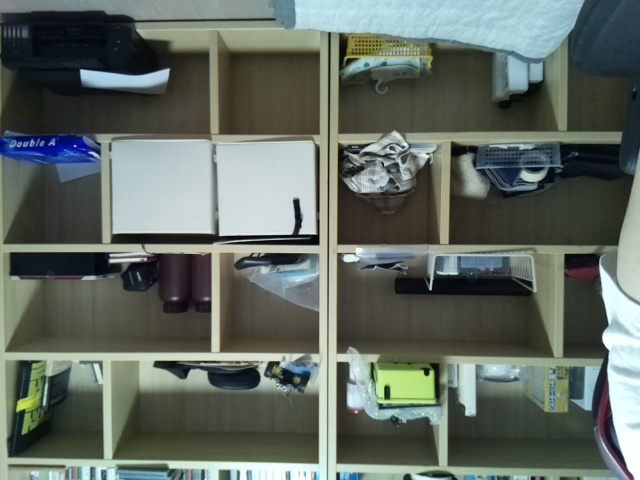

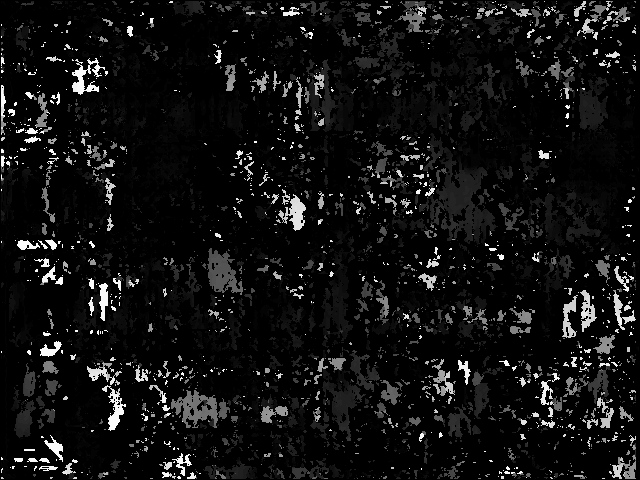

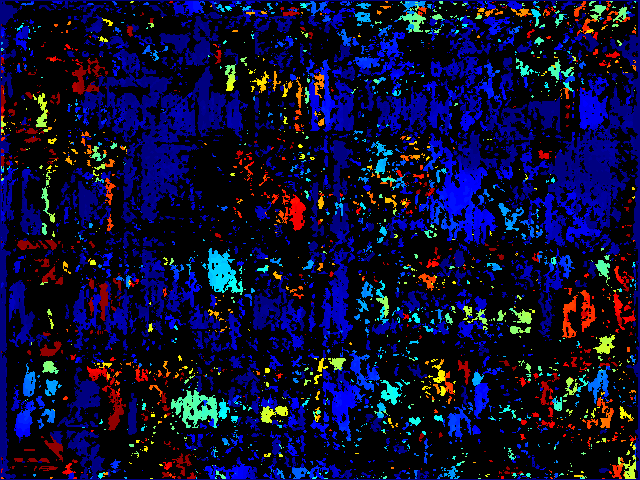

In [18]:
from google.colab.patches import cv2_imshow
import cv2

left = cv2.imread('./frame0001.jpg')
disparity = cv2.imread('./disparity.png')
disparity_color = cv2.imread('./disparity_color.png')

cv2_imshow(left)
cv2_imshow(disparity)
cv2_imshow(disparity_color)

In [16]:
from google.colab.patches import cv2_imshow
import cv2

left = cv2.imread('./left.png')
disparity = cv2.imread('./disparity.png')
disparity_color = cv2.imread('./disparity_color.png')

cv2_imshow(left)
cv2_imshow(disparity)
cv2_imshow(disparity_color)

AttributeError: ignored